# Parameters

In [1]:
# don't change

REFERENCE_MISSION = 2

RESIZE_SCALE = 0.1

REFERENCE_CROP_L = 30
REFERENCE_CROP_R = 145
REFERENCE_CROP_T = 80
REFERENCE_CROP_B = 90

REGION_NAMES = ['GRASS', 'SIDEWALK', 'BUILDING', 'GRAVEL']

# Imports and Functions

In [2]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [4]:
def get_mission_segmentation_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '_segmentation\\mission_' + str(mission_number) + '_'

In [5]:
def plot_images(image_list, title_list=[], grid='off'):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [6]:
def load_images_and_masks(mission_number, is_mission_image, file_name=''):
    print('----')
    if is_mission_image:
        result = cv2.imread(get_mission_segmentation_file_path(mission_number) + 'bordered.png').astype(np.uint8)
        print(result.shape)
        result = cv2.resize(result, (0,0), fx=RESIZE_SCALE, fy=RESIZE_SCALE)
        print('mission image:', result.shape)
    else:
        result = dict()
        for name in REGION_NAMES:
            if mission_number == REFERENCE_MISSION:
                mask = np.load(get_mission_segmentation_file_path(REFERENCE_MISSION) + file_name + '_%s.npy' % (name)).astype(np.uint8)*255
                print(mask.shape)
                mask = cv2.resize(mask, (0,0), fx=RESIZE_SCALE, fy=RESIZE_SCALE)
            else:
                print('load reference mask')
#                 print(get_mission_file_path(REFERENCE_MISSION) + file_name + '_%s.npy' % (name))
                mask = np.load(get_mission_file_path(REFERENCE_MISSION) + file_name + '_%s.npy' % (name)) # no .astype(np.uint8)*255
            print(name, ':', mask.shape)
            result[name] = mask

    return result

In [7]:
def get_aligned_global_image(mission_number):
    mission = np.load(get_mission_file_path(mission_number) + 'aligned_image.npy')
    return mission

In [8]:
def calculate_masked_images(mission_image, masks):
    images = dict()
    for name in REGION_NAMES:
        image = cv2.bitwise_and(mission_image, mission_image, mask=masks[name])
        images[name] = image.astype(np.uint8)

    return images

In [9]:
def save_images_and_masks(mission_number, images, is_mission_image, filename):
    if is_mission_image:
        np.save(get_mission_file_path(mission_number) + filename + '.npy', images)
    else:
        for name in REGION_NAMES:
            np.save(get_mission_file_path(mission_number) + filename + '_%s.npy' % (name), images[name])

In [10]:
def align_to_reference_helper_1(im1, im2):
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.15
    
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))

    return im1Reg, h

In [11]:
def detectAndDescribe(image, method):
    # compute key points and feature descriptors
        
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

def createMatcher(method, crossCheck):    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(features_global, features_add, method):
    bf = createMatcher(method, crossCheck=True) # cross check f1 closest to f2 and f2 closest to f1
    
    # Match descriptors.
    best_matches = bf.match(features_global, features_add)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches:", len(rawMatches))
    return rawMatches

def getHomography(kp_add, kp_global, features_add, features_global, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kp_add = np.float32([kp.pt for kp in kp_add])
    kp_global = np.float32([kp.pt for kp in kp_global])
    
    if len(matches) > 4:

        # construct the two sets of points
        pts_add = np.float32([kp_add[m.queryIdx] for m in matches])
        pts_global = np.float32([kp_global[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(pts_add, pts_global, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None


def align_to_reference_helper_2(im1, im2):
    feature_extractor = 'brisk'

    add_img_gray = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
    global_img_gray = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

    kp_global, features_global = detectAndDescribe(global_img_gray, method=feature_extractor)
    kp_add, features_add = detectAndDescribe(add_img_gray, method=feature_extractor)

    matches = matchKeyPointsBF(features_add, features_global, method=feature_extractor)

    M = getHomography(kp_add, kp_global, features_add, features_global, matches, reprojThresh=4)
    if M is None:
        print("Error!")
    (matches, H, status) = M
    
    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, H, (width, height))

    return im1Reg, H

In [12]:
def align_to_reference(mission_number, images, is_mission_image):
    print('----')
    
    if mission_number == REFERENCE_MISSION:
        print('no alignment')

        # first time need to save the mission image because it'll be used for future alignments
        # check if reference is saved, if not then save here
#         NEED_TO_SAVE = not os.path.isfile(get_mission_file_path(REFERENCE_MISSION) + 'aligned_image.npy')  
#         print(NEED_TO_SAVE)
#         if NEED_TO_SAVE:
#             return -1 # need to run this with REFERENCE_MISSION first
        
        if is_mission_image:
            h_ref, w_ref, _ = images.shape
        else:
            h_ref, w_ref = images[REGION_NAMES[0]].shape
            
        aligned_images = copy.deepcopy(images)
    else:
        # perform alignment
        print('alignment')
        reference_mission = np.load(get_mission_file_path(REFERENCE_MISSION) + 'aligned_image.npy')
        h_ref, w_ref, c_ref = reference_mission.shape
        if is_mission_image:
            tobealigned_mission = images
            aligned_mission, H = align_to_reference_helper_2(tobealigned_mission, reference_mission) # NOTE helper_2 not helper_1
            
            np.save(get_mission_file_path(mission_number) + 'H_from_mission_' + str(REFERENCE_MISSION) + '.npy', H)
            
            aligned_images = aligned_mission
            print(aligned_images.shape)
        else:
            H = np.load(get_mission_file_path(mission_number) + 'H_from_mission_' + str(REFERENCE_MISSION) + '.npy')
            # must be same shape, which it is. use same H
            
            aligned_images = dict()
            for name in REGION_NAMES:
                aligned_image = cv2.warpPerspective(images[name], H, (w_ref, h_ref))
                aligned_images[name] = aligned_image
    
    if mission_number == REFERENCE_MISSION:
        if is_mission_image: # for global image
            result = copy.deepcopy(aligned_images)[REFERENCE_CROP_T:h_ref-REFERENCE_CROP_B, REFERENCE_CROP_L:w_ref-REFERENCE_CROP_R, :]
            print(result.shape)
        else: # for region and sample masks
            result = dict()
            for k, v in aligned_images.items():
                result[k] = copy.deepcopy(v)[REFERENCE_CROP_T:h_ref-REFERENCE_CROP_B, REFERENCE_CROP_L:w_ref-REFERENCE_CROP_R]
                print(result[k].shape)
        return result
    else:
        return aligned_images

In [13]:
from skimage import color

def separate_channels(I):
    I = color.rgb2lab(I)
    I = I.astype(np.float32)
    I1, I2, I3 = (I[:, :, 0], I[:, :, 1], I[:, :, 2])
    I1 /= 2.55
    I2 -= 128.0
    I3 -= 128.0
    return I1, I2, I3

def get_mean_and_std(channels):
    mean = (np.mean(channels[0]), np.mean(channels[1]), np.mean(channels[2]))
    std = (np.std(channels[0]), np.std(channels[1]), np.std(channels[2]))
    return mean, std

def merge_channels(I1, I2, I3):
    I1 *= 2.55
    I2 += 128.0
    I3 += 128.0
    
    I = np.stack((I1, I2, I3), axis=2)
    return color.lab2rgb(I)

#fit source to target
def single_reinhard(target, source):
    target_channels = separate_channels(target)
    source_channels = separate_channels(source)
    
    source_mean, source_std = get_mean_and_std(source_channels)
    target_mean, target_std = get_mean_and_std(target_channels)
    
    modified1 = ((source_channels[0] - source_mean[0]) * (target_std[0] / source_std[0])) + target_mean[0]
    modified2 = ((source_channels[1] - source_mean[1]) * (target_std[1] / source_std[1])) + target_mean[1]
    modified3 = ((source_channels[2] - source_mean[2]) * (target_std[2] / source_std[2])) + target_mean[2]
    
    return merge_channels(modified1, modified2, modified3)*255

# Start

In [40]:
mission_number = 14

if not os.path.isdir('..\\missions\\mission_' + str(mission_number)):
    os.mkdir('..\\missions\\mission_' + str(mission_number))

mission_image = load_images_and_masks(mission_number, is_mission_image=True, file_name='')
if mission_number == REFERENCE_MISSION:
    regions_mask = load_images_and_masks(mission_number, is_mission_image=False, file_name='region_mask')
    samples_mask = load_images_and_masks(mission_number, is_mission_image=False, file_name='sample_mask')

----
(7271, 6386, 3)
mission image: (727, 639, 3)


In [41]:
aligned_mission_image = align_to_reference(mission_number, mission_image, is_mission_image=True) # need to run this first to get homography matrix
if mission_number == REFERENCE_MISSION:
    aligned_regions_mask = align_to_reference(mission_number, regions_mask, is_mission_image=False)
    aligned_samples_mask = align_to_reference(mission_number, samples_mask, is_mission_image=False)
else: # load prealigned masks
    aligned_regions_mask = load_images_and_masks(mission_number, is_mission_image=False, file_name='aligned_region_mask')
    aligned_samples_mask = load_images_and_masks(mission_number, is_mission_image=False, file_name='aligned_sample_mask')

print('\n----------\n')
print(aligned_mission_image.shape)
for name in REGION_NAMES:
    print(name, ':', aligned_regions_mask[name].shape)
for name in REGION_NAMES:
    print(name, ':', aligned_samples_mask[name].shape)
    
# final image sizes (543, 470, 3)
# final mask sizes (543, 470)

----
alignment
Raw matches: 493
(543, 470, 3)
----
load reference mask
GRASS : (543, 470)
load reference mask
SIDEWALK : (543, 470)
load reference mask
BUILDING : (543, 470)
load reference mask
GRAVEL : (543, 470)
----
load reference mask
GRASS : (543, 470)
load reference mask
SIDEWALK : (543, 470)
load reference mask
BUILDING : (543, 470)
load reference mask
GRAVEL : (543, 470)

----------

(543, 470, 3)
GRASS : (543, 470)
SIDEWALK : (543, 470)
BUILDING : (543, 470)
GRAVEL : (543, 470)
GRASS : (543, 470)
SIDEWALK : (543, 470)
BUILDING : (543, 470)
GRAVEL : (543, 470)


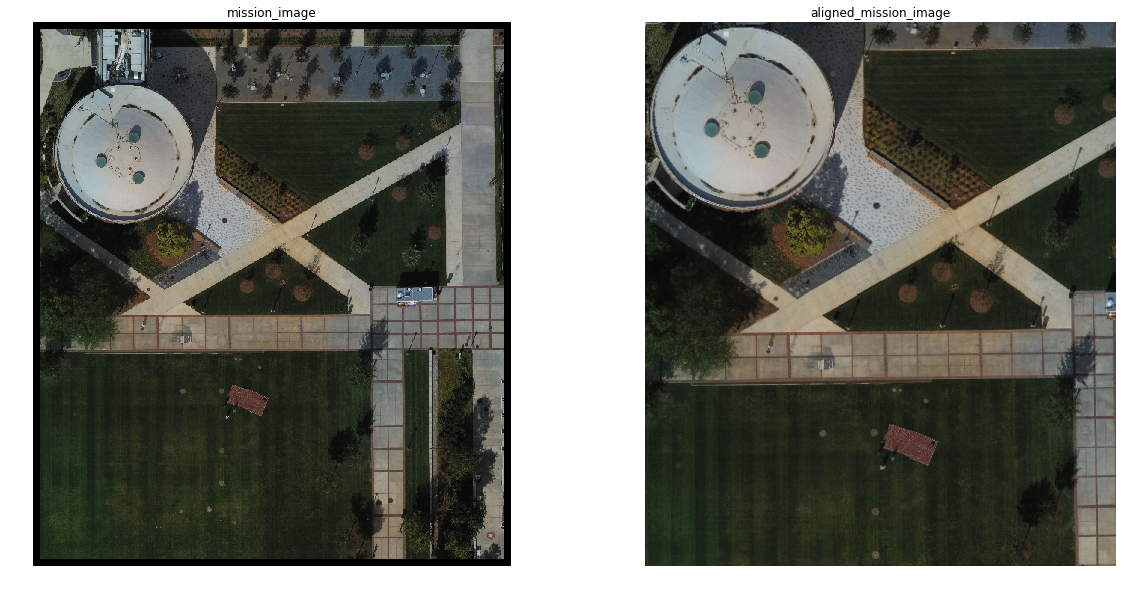

In [42]:
plot_images([mission_image, aligned_mission_image], ['mission_image', 'aligned_mission_image'])

# Masks

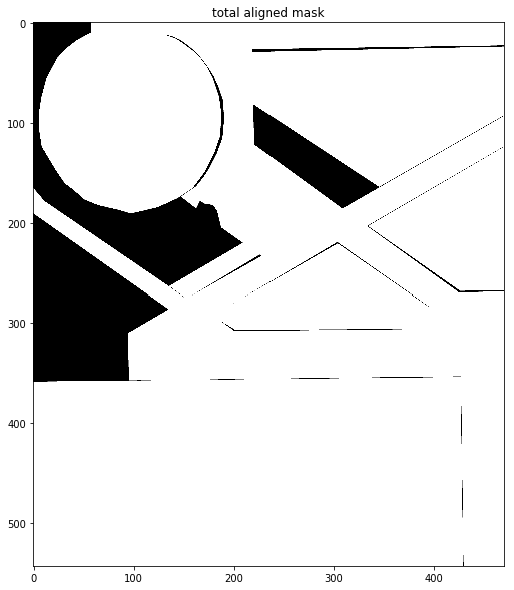

In [43]:
plot_images([cv2.bitwise_or(cv2.bitwise_or(aligned_regions_mask[REGION_NAMES[0]], aligned_regions_mask[REGION_NAMES[1]]), cv2.bitwise_or(aligned_regions_mask[REGION_NAMES[2]], aligned_regions_mask[REGION_NAMES[3]]))], ['total aligned mask'], grid='on')

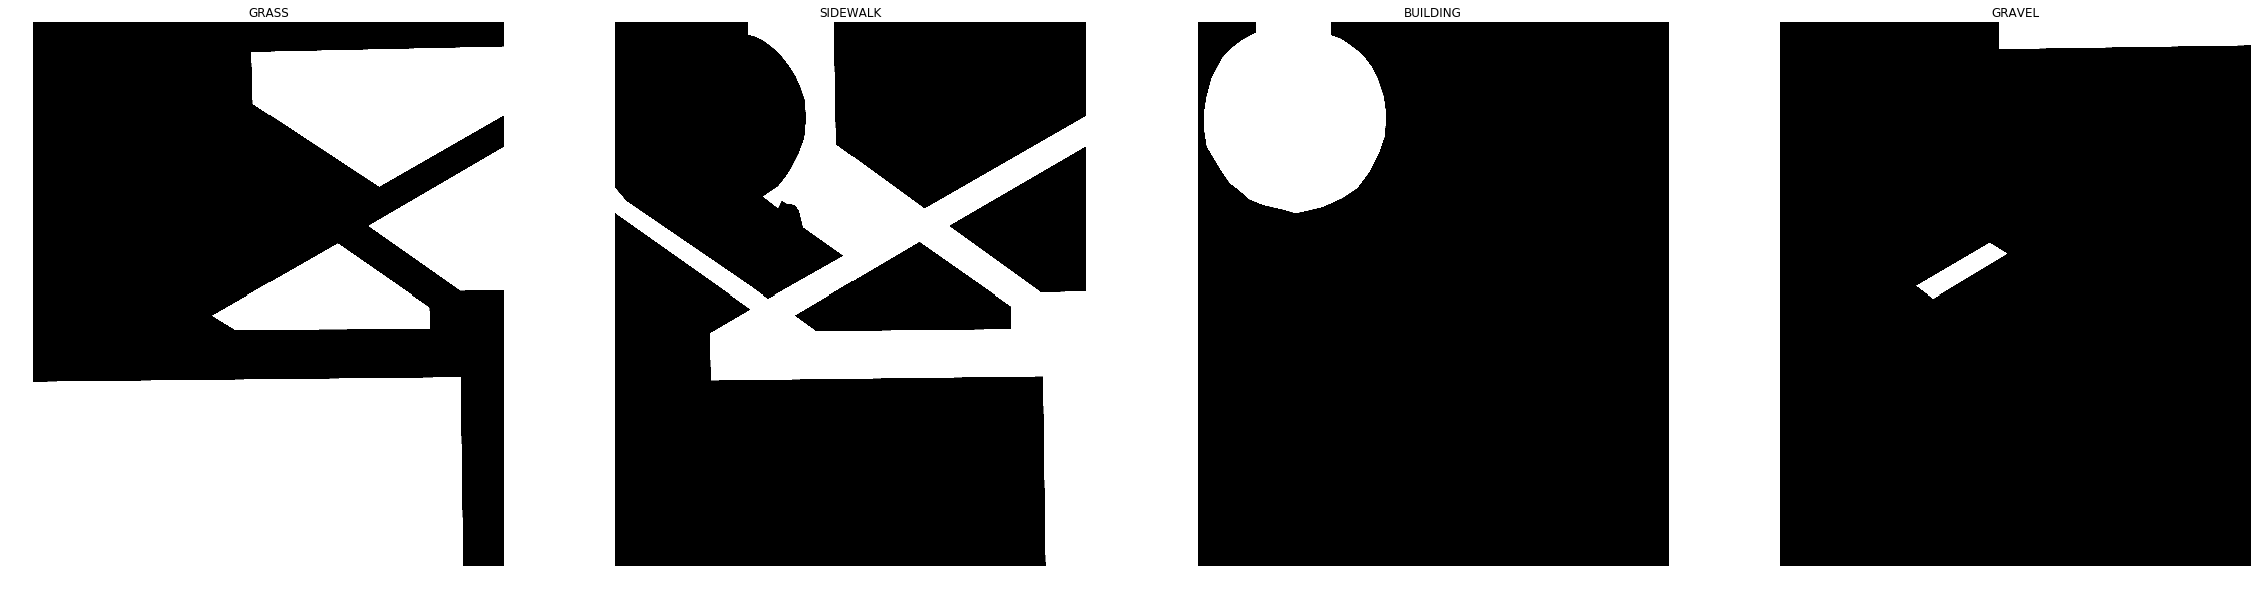

In [44]:
if mission_number == REFERENCE_MISSION:
    plot_images(list(regions_mask.values()), REGION_NAMES)

plot_images(list(aligned_regions_mask.values()), REGION_NAMES)

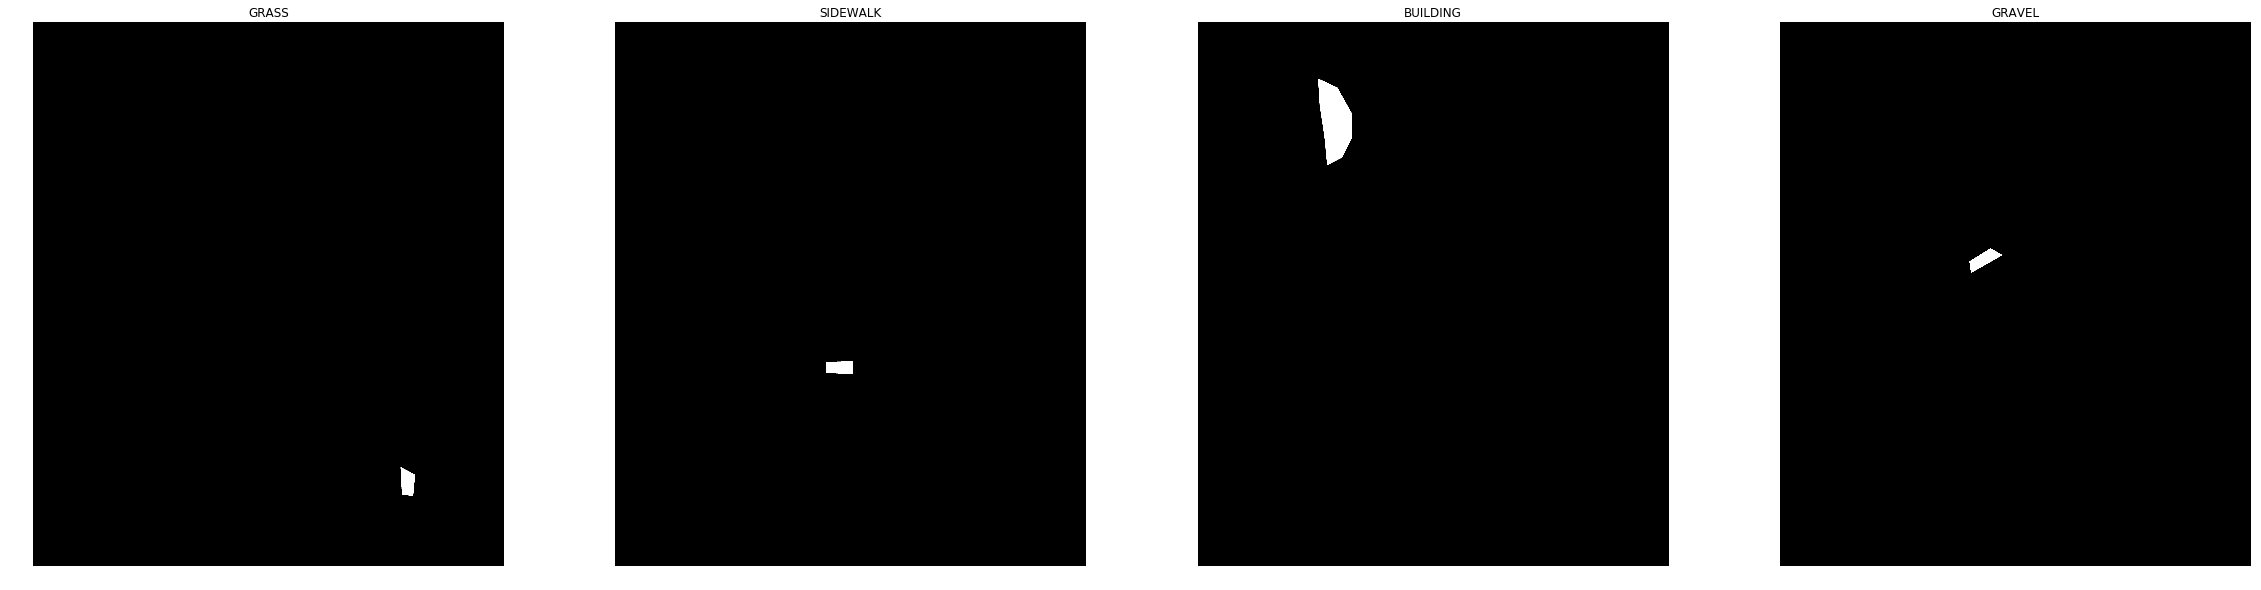

In [45]:
if mission_number == REFERENCE_MISSION:
    plot_images(list(samples_mask.values()), REGION_NAMES)

plot_images(list(aligned_samples_mask.values()), REGION_NAMES)

# Aligned Image Results

In [46]:
aligned_regions_image = calculate_masked_images(aligned_mission_image, aligned_regions_mask)
aligned_samples_image = calculate_masked_images(aligned_mission_image, aligned_samples_mask)

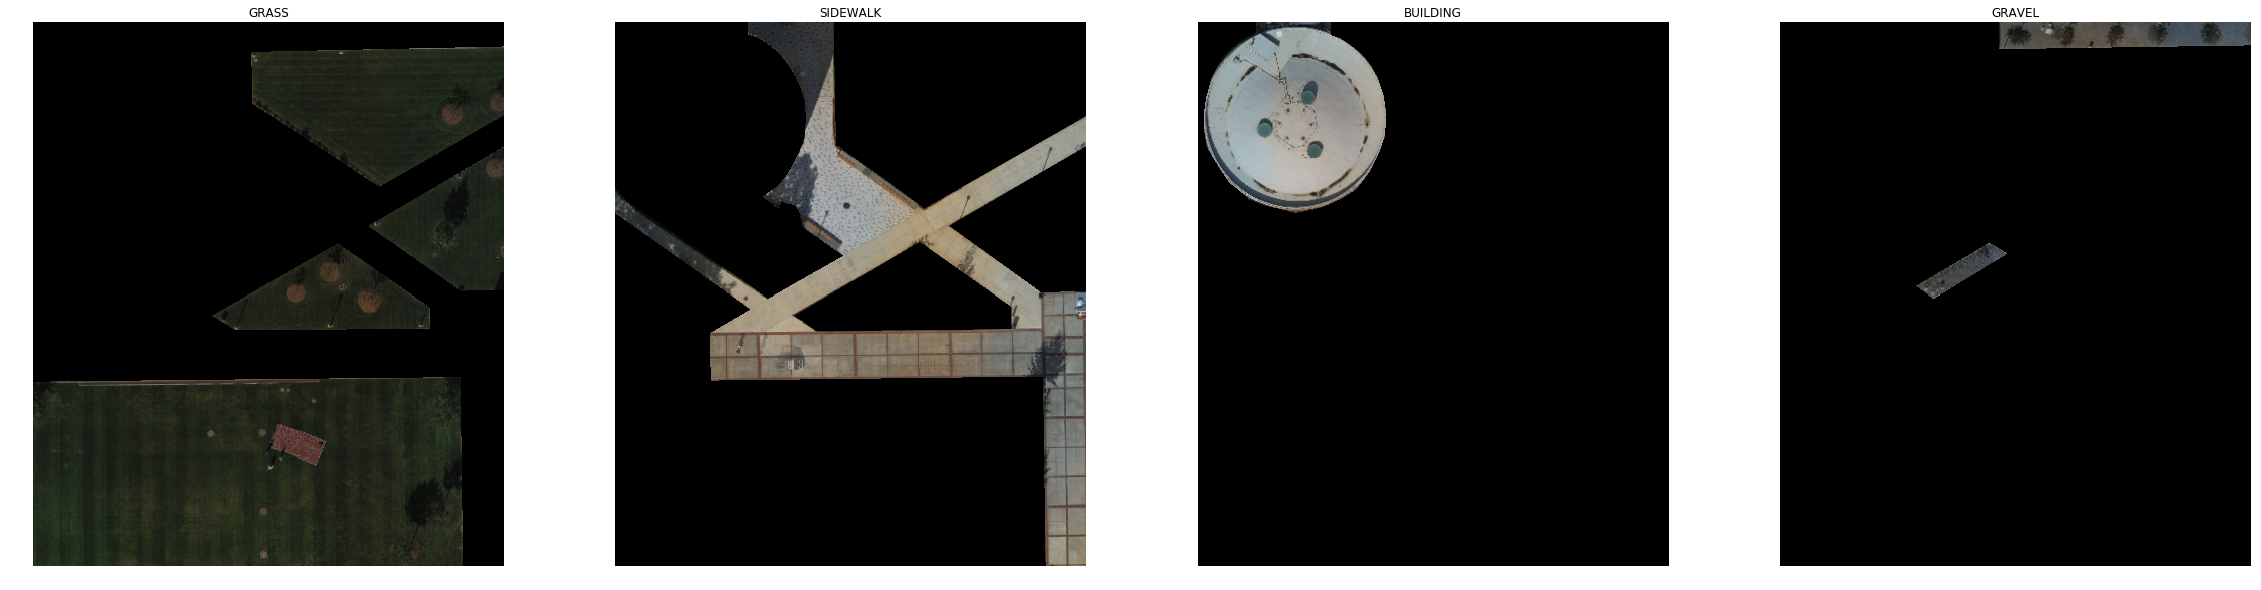

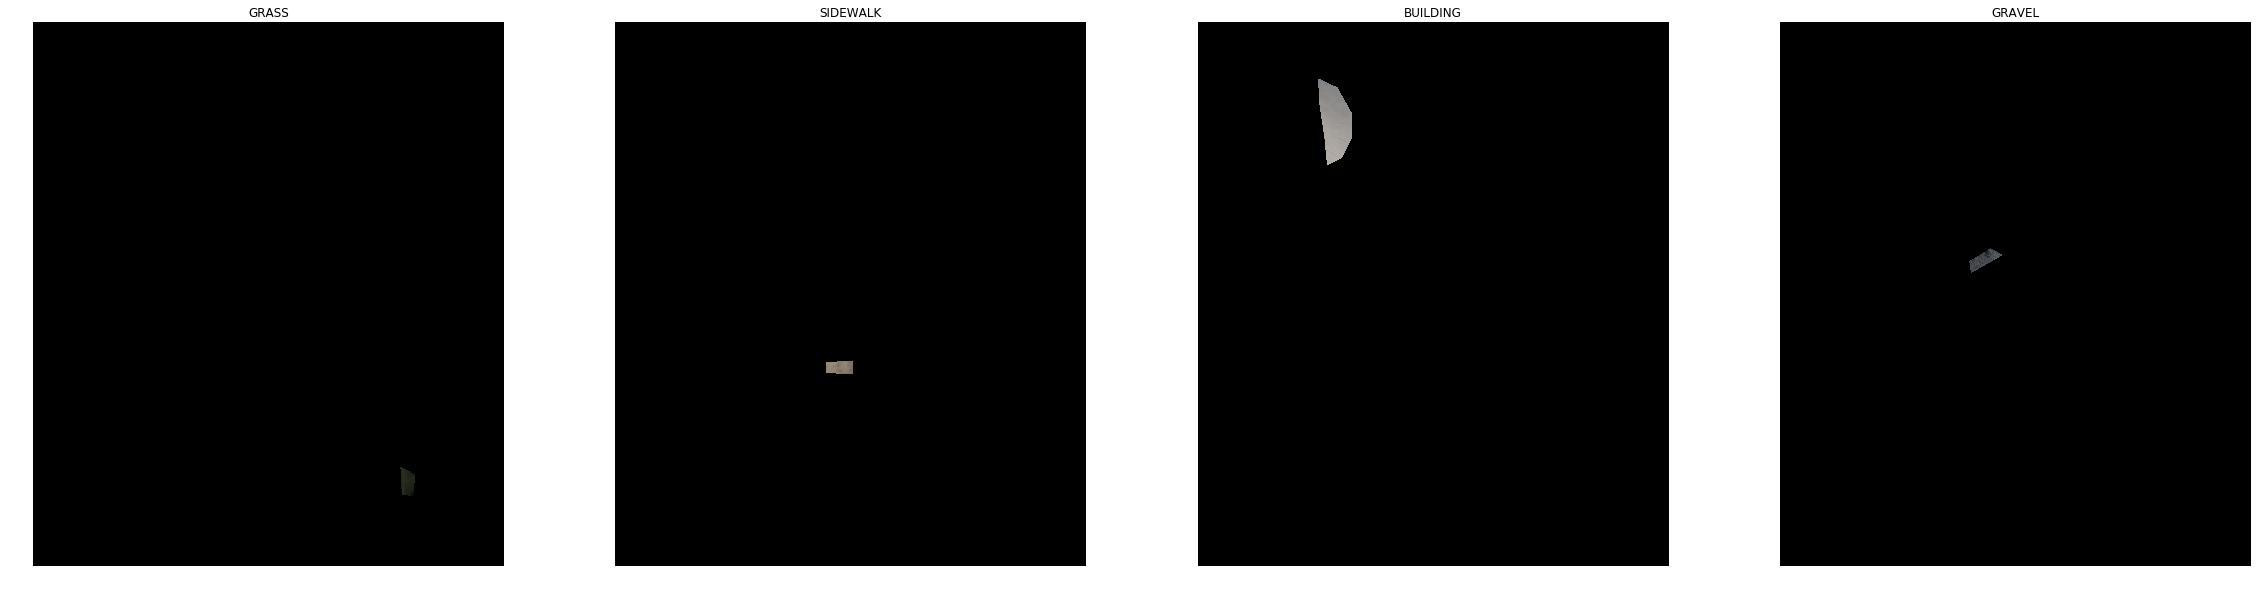

In [47]:
plot_images(list(aligned_regions_image.values()), REGION_NAMES)
plot_images(list(aligned_samples_image.values()), REGION_NAMES)

# Normalized Image Results

In [48]:
if mission_number == REFERENCE_MISSION:
    target = copy.deepcopy(aligned_mission_image)
else:
    target = get_aligned_global_image(REFERENCE_MISSION)

normalized_mission_image = single_reinhard(target, aligned_mission_image).astype(np.uint8)

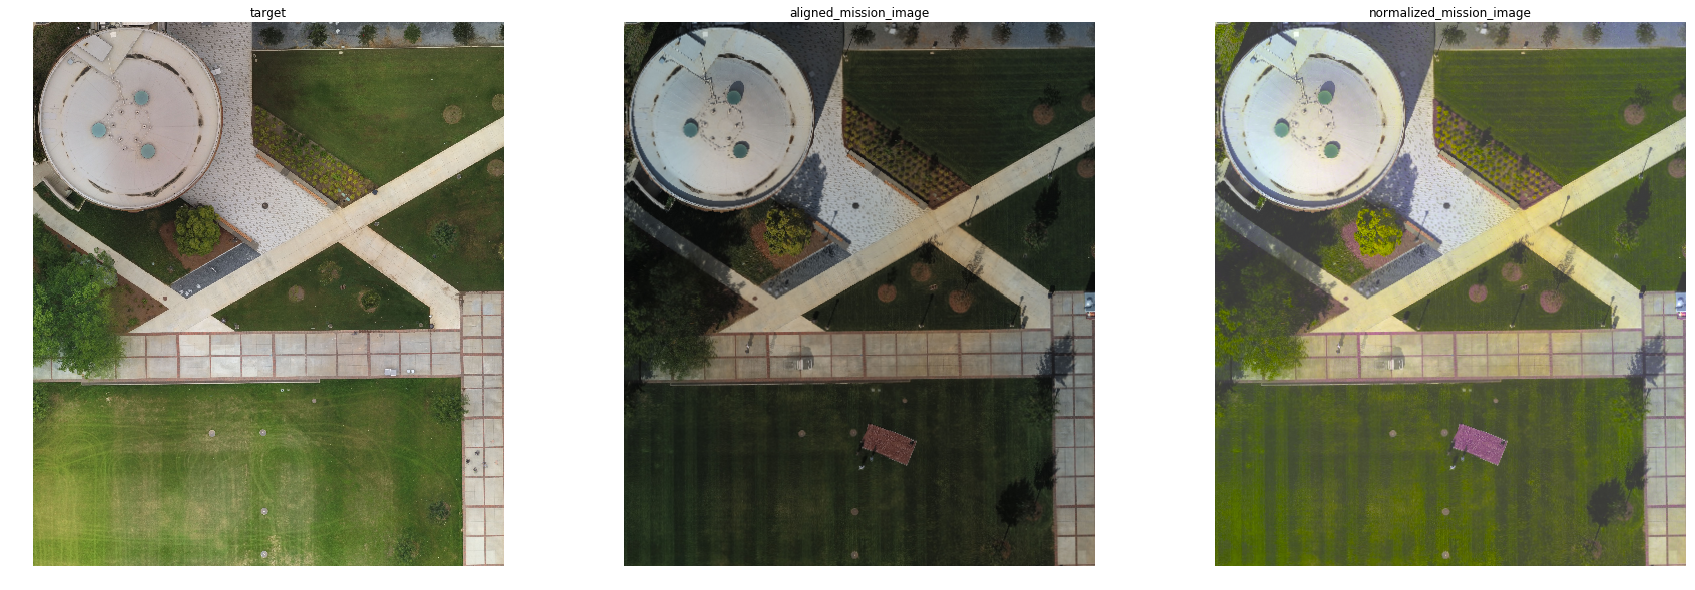

In [49]:
plot_images([target, aligned_mission_image, normalized_mission_image], ['target', 'aligned_mission_image', 'normalized_mission_image'])

In [50]:
normalized_regions_image = calculate_masked_images(normalized_mission_image, aligned_regions_mask)
normalized_samples_image = calculate_masked_images(normalized_mission_image, aligned_samples_mask)

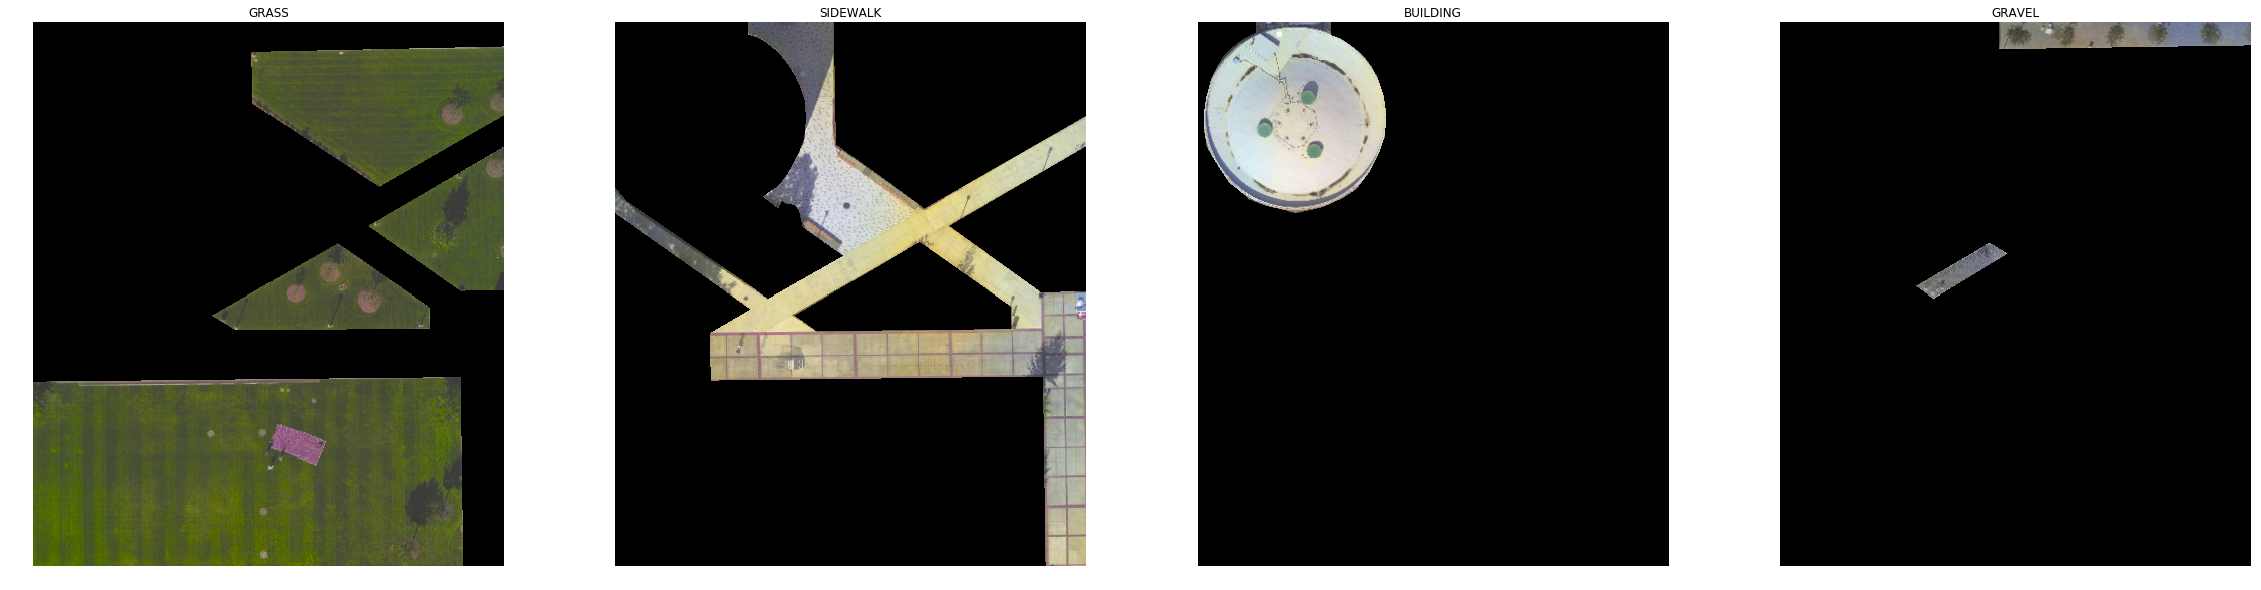

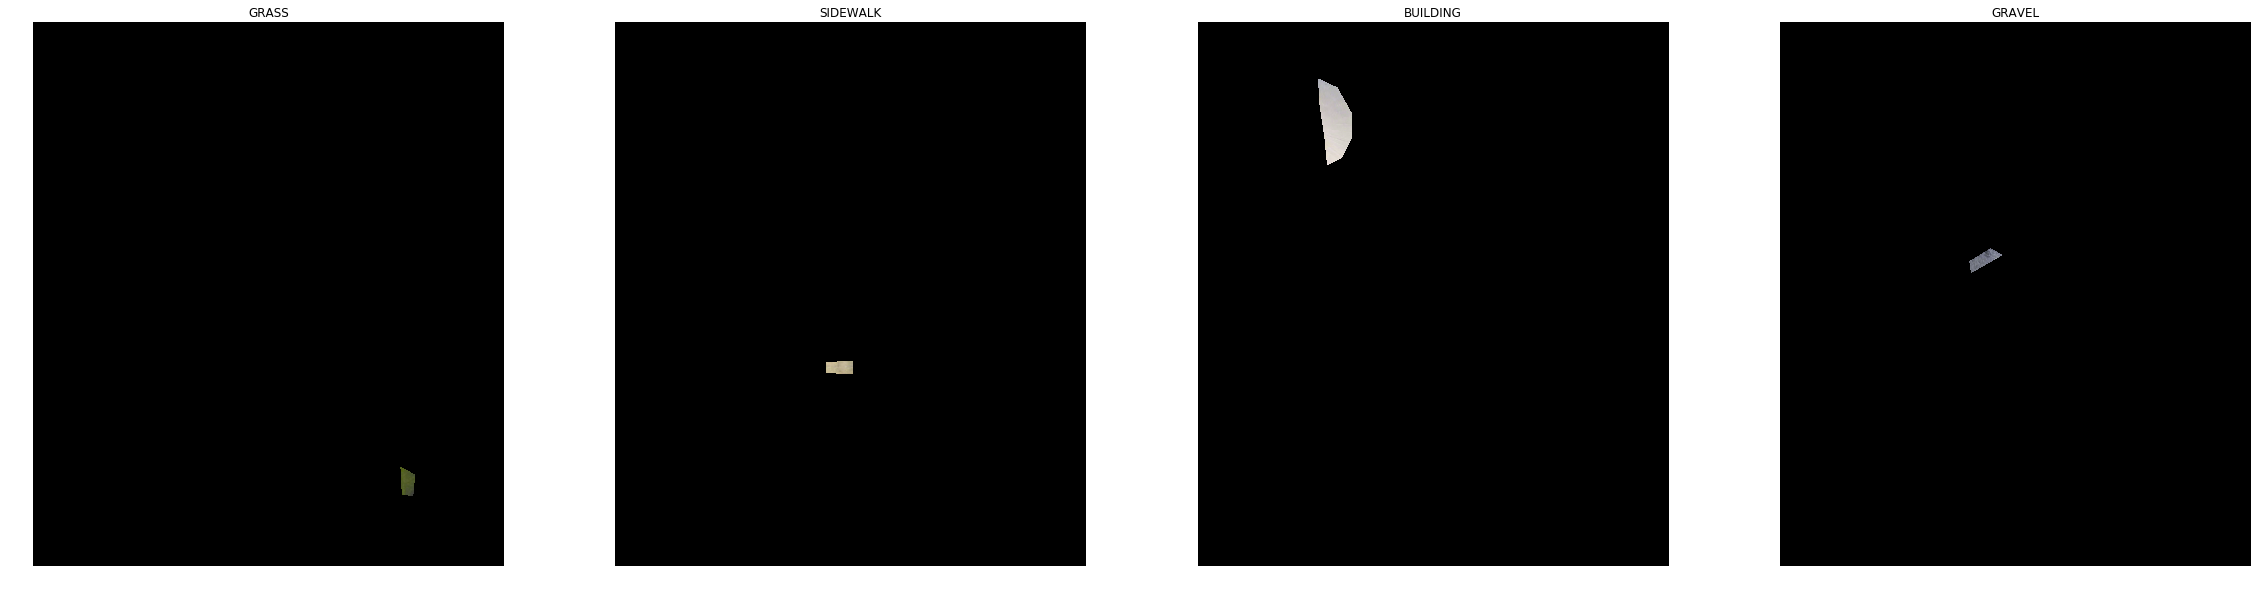

In [51]:
plot_images(list(normalized_regions_image.values()), REGION_NAMES)
plot_images(list(normalized_samples_image.values()), REGION_NAMES)

# Save

In [52]:
save_images_and_masks(mission_number, aligned_mission_image, is_mission_image=True, filename='aligned_image')
save_images_and_masks(mission_number, normalized_mission_image, is_mission_image=True, filename='normalized_image')

save_images_and_masks(mission_number, aligned_regions_image, is_mission_image=False, filename='aligned_region_image')
save_images_and_masks(mission_number, aligned_samples_image, is_mission_image=False, filename='aligned_sample_image')

save_images_and_masks(mission_number, normalized_regions_image, is_mission_image=False, filename='normalized_region_image')
save_images_and_masks(mission_number, normalized_samples_image, is_mission_image=False, filename='normalized_sample_image')

if mission_number == REFERENCE_MISSION:
    save_images_and_masks(mission_number, aligned_regions_mask, is_mission_image=False, filename='aligned_region_mask')
    save_images_and_masks(mission_number, aligned_samples_mask, is_mission_image=False, filename='aligned_sample_mask')